In [1]:
using LinearAlgebra, Distributions, Plots, Random, Zygote, MLDatasets
include("simple_nn.jl");

# XOR Problem

In [2]:
data = [
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0]
]

targets = [
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 0.0],
    [0.0, 1.0]
];

In [3]:
xor_net = CreateNetwork([
    [2],
    [2, dense_layer, sigmoid_activation],
    [2, dense_layer, sigmoid_activation]
]);

In [4]:
OptimizerSetup!(xor_net, GradientDescentOptimizer!, learning_rate=0.01)

Dict{String, Any} with 3 entries:
  "optimizer"      => GradientDescentOptimizer!
  "optimizer_name" => "GradientDescentOptimizer!"
  "learning_rate"  => 0.01

In [5]:
epochs = 250

loss = 0.0
losses = []

cross_entropy_loss(x_in, y_val) = -sum(y_val .* log.(Forward(xor_net, x_in)))

for epoch in 1:epochs
    for (i, input) in enumerate(data)
        x_in = convert(Vector{Float32}, input)
        y_val = targets[i]
        
        pred = Forward(xor_net, x_in)
        loss = cross_entropy_loss(x_in, y_val)
        
        Backward!(xor_net, cross_entropy_loss, x_in, y_val)
        
        if epoch % 50 == 0 && i == length(targets)
            println("Epoch $epoch\tPred: $(round(maximum(pred), digits=4))\tTarget: $(maximum(y_val))\tloss: $(round(loss, digits=4))")
        end
    end
    push!(losses, loss)
end

preds = round.(maximum.([Forward(xor_net, convert(Vector{Float32}, x)) for x in data]))
passed = preds .== convert(Vector{Float32}, maximum.(targets))

println("\n$(sum(passed))/4 tests passed | Accuracy $(100 * sum(passed) / length(targets))%")

Epoch 50	Pred: 0.5232	Target: 1.0	loss: 0.8291
Epoch 100	Pred: 0.6924	Target: 1.0	loss: 0.3782
Epoch 150	Pred: 0.8064	Target: 1.0	loss: 0.2152
Epoch 200	Pred: 0.8673	Target: 1.0	loss: 0.1423
Epoch 250	Pred: 0.9017	Target: 1.0	loss: 0.1035

4/4 tests passed | Accuracy 100.0%


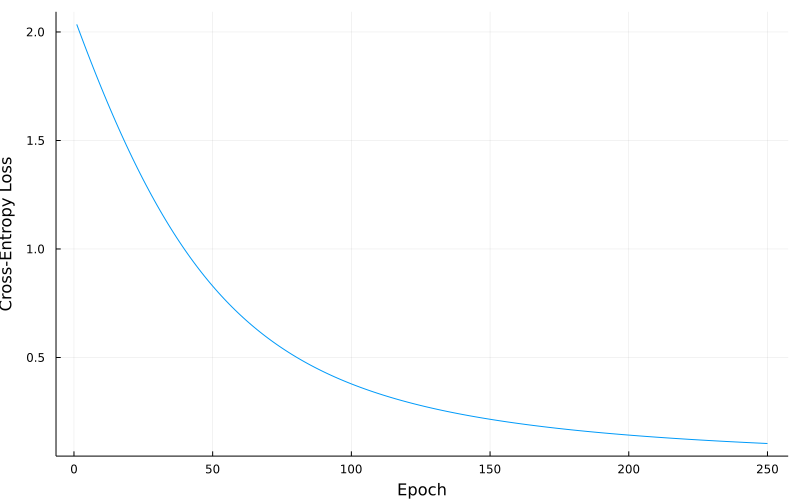

In [6]:
plot(losses, xlabel="Epoch", ylabel="Cross-Entropy Loss", label="", size=(800,500))

## Comparing Optimizers

In [7]:
xor_net_gd = CreateNetwork([
    [2],
    [2, dense_layer, sigmoid_activation],
    [2, dense_layer, sigmoid_activation]
])

xor_net_mgd = CreateNetwork([
    [2],
    [2, dense_layer, sigmoid_activation],
    [2, dense_layer, sigmoid_activation]
]);

In [8]:
loss_gd = 0.0
loss_mgd = 0.0

losses_gd = []
losses_mgd = []

OptimizerSetup!(xor_net_gd, GradientDescentOptimizer!, learning_rate=0.01)
OptimizerSetup!(xor_net_mgd, MomentumOptimizer!, learning_rate=0.01, gamma=0.9)

cross_entropy_loss_gd(x_in, y_val) = -sum(y_val .* log.(Forward(xor_net_gd, x_in)))
cross_entropy_loss_mgd(x_in, y_val) = -sum(y_val .* log.(Forward(xor_net_mgd, x_in)))

for epoch in 1:epochs
    for (i, input) in enumerate(data)
        x_in = convert(Vector{Float32}, input)
        y_val = targets[i]
        
        loss_gd = cross_entropy_loss_gd(x_in, y_val)
        loss_mgd = cross_entropy_loss_mgd(x_in, y_val)
        
        Backward!(xor_net_gd, cross_entropy_loss_gd, x_in, y_val)
        Backward!(xor_net_mgd, cross_entropy_loss_mgd, x_in, y_val)
    end
    
    push!(losses_gd, loss_gd)
    push!(losses_mgd, loss_mgd)
end

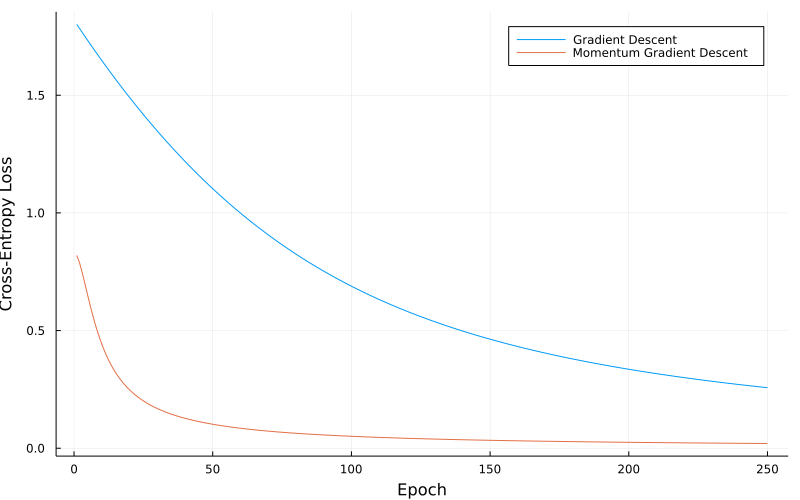

In [9]:
plot(losses_gd, xlabel="Epoch", ylabel="Cross-Entropy Loss", label="Gradient Descent", size=(800,500))
plot!(losses_mgd, label="Momentum Gradient Descent")

# MNIST

In [10]:
train_set = MNIST(:train)
test_set = MNIST(:test);

In [11]:
# helper functions
flatten(matrix) = vcat(matrix...)

function one_hot_encoding(target)
    return Float32.(target .== collect(0:9))
end

one_hot_encoding (generic function with 1 method)

In [12]:
mnist_network = CreateNetwork([
    [784],
    [128, dense_layer, sigmoid_activation],
    [64, dense_layer, sigmoid_activation],
    [10, dense_layer, softmax_activation]
])

OptimizerSetup!(mnist_network, MomentumOptimizer!, learning_rate=0.01)

Dict{String, Any} with 6 entries:
  "optimizer"               => MomentumOptimizer!
  "weights_momentum_vector" => [[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 …
  "optimizer_name"          => "MomentumOptimizer!"
  "learning_rate"           => 0.01
  "gamma"                   => 0.9
  "biases_momentum_vector"  => [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…

In [13]:
epochs = 500

loss = 0.0
losses = []

batch_size = 32

cross_entropy_loss(x_in, y_val) = -sum(y_val .* log.(Forward(mnist_network, x_in)))

for epoch in 1:epochs
    batch_idx = rand((1:length(train_set)), batch_size)
    batch_data = [train_set[idx] for idx in batch_idx]
    
    for i in 1:batch_size
        x_in = convert(Vector{Float32}, flatten(batch_data[i].features))
        y_val = one_hot_encoding(batch_data[i].targets)
        
        pred = Forward(mnist_network, x_in)
        loss = cross_entropy_loss(x_in, y_val)
        
        Backward!(mnist_network, cross_entropy_loss, x_in, y_val)
    end
    push!(losses, loss)
end

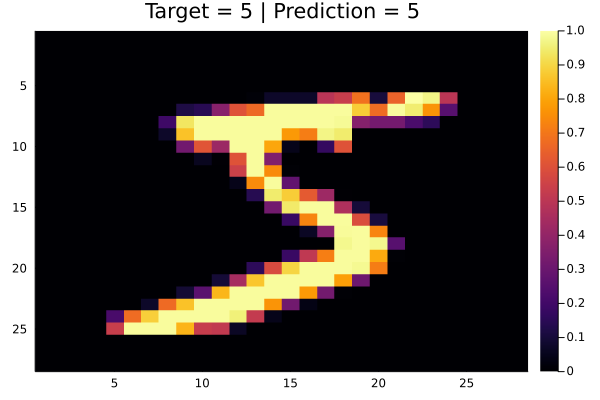

In [14]:
samp = 1

test_pred = Forward(mnist_network, convert(Vector{Float32}, flatten(train_set[samp].features)))
pred = findmax(test_pred)[2] - 1

heatmap(train_set[samp].features', yflip=true, title="Target = $(train_set[samp].targets) | Prediction = $pred")

In [18]:
test_predictions = argmax.([
    Forward(mnist_network, convert(Vector{Float32}, flatten(samp.features))) for samp in test_set
]) .- 1

test_targets = [samp.targets for samp in test_set]
test_correct = test_predictions .== test_targets

println("Accuracy: $(round(100 * sum(test_correct) / length(test_correct), digits=2))%")

Accuracy: 87.39%
